In [70]:
#pip install tensorflow

In [71]:
#pip install matplotlib

In [72]:
#pip install climetlab

In [73]:
#pip install climetlab-eumetnet-postprocessing-benchmark

In [74]:
#pip install --upgrade jupyterlab ipywidgets

In [75]:
#pip install requests

In [76]:
#pip install tensorrt

In [77]:
#pip install plotly


In [9]:
#start

In [47]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import joblib  # For saving scaler model
import os
import pickle
import plotly.graph_objects as go
import pandas as pd
import climetlab as cml

from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, ConvLSTM2D, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.regularizers import l2
from keras.callbacks import ModelCheckpoint

In [40]:
def fetch_data(start_date = '2018-01-01T00', end_date='2024-01-01T00'):
    url_template = ("https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?"
                    "parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&"
                    "parameters=RH2M&parameters=UU&parameters=VV&start={start_date}%3A00&"
                    "end={end_date}%3A00&lat_lon=48.333056%2C16.631944&"
                    "lat_lon=48.115278%2C16.175833&output_format=geojson&"
                    "filename=INCA_Vienna_timeseries_all_parameters_{start_year}_{end_year}")
    formatted_url = url_template.format(start_date=start_date, end_date=end_date, 
                                        start_year=start_date[:4], end_year=end_date[:4])
    print(formatted_url)
    response = requests.get(formatted_url)
    if response.status_code == 200:
        data = response.json()
        print("Fetched data successfully")
    else:
        print("Failed to retrieve data", response.status_code)

    # Processing the data
    data_list = []
    for feature in data['features']:
        location = feature['geometry']['coordinates']
        for i, timestamp in enumerate(data['timestamps']):
            record = {
                'time': pd.to_datetime(timestamp),
                'longitude': location[0],
                'latitude': location[1],
                'RR': feature['properties']['parameters']['RR']['data'][i],
                'T2M': feature['properties']['parameters']['T2M']['data'][i],
                'RH2M': feature['properties']['parameters']['RH2M']['data'][i],
                'TD2M': feature['properties']['parameters']['TD2M']['data'][i],
                'GL': feature['properties']['parameters']['GL']['data'][i],
                'UU': feature['properties']['parameters']['UU']['data'][i],
                'VV': feature['properties']['parameters']['VV']['data'][i],
                'P0': feature['properties']['parameters']['P0']['data'][i]
            }
            data_list.append(record)

    original_df = pd.DataFrame(data_list)
    return original_df


In [54]:
def calculate_rolling_features(df, window_size, feature_name):
    if len(df) < window_size:
        window_size = len(df)  # Adjust window size to length of the data if data is too short
    df[f'{feature_name}_rolling_mean'] = df['T2M'].rolling(window=window_size).mean()
    df[f'{feature_name}_rolling_max'] = df['T2M'].rolling(window=window_size).max()
    df[f'{feature_name}_rolling_min'] = df['T2M'].rolling(window=window_size).min()
    df[f'{feature_name}_rolling_std'] = df['T2M'].rolling(window=window_size).std()

def calculate_ewm_features(df, span, feature_name):
    df[f'{feature_name}_ewm'] = df['T2M'].ewm(span=span, adjust=False).mean()

def handle_na(df):
    df.fillna(method='ffill', inplace=True)  # Forward fill first to propagate last valid observation forward
    df.fillna(method='bfill', inplace=True)  # Backward fill to ensure no NaNs remain

def feature_engineering(df):
    df.dropna(inplace=True)  # Drop rows with NaN values first
    original_time_index = df['time'].copy()
    # Basic date-time features
    df['hour'] = df['time'].dt.hour
    df['day_of_year'] = df['time'].dt.dayofyear
    df['week_of_year'] = df['time'].dt.isocalendar().week
    df['day_of_month'] = df['time'].dt.day
    df['month'] = df['time'].dt.month
    df['year'] = df['time'].dt.year

    # Wind and interaction features
    df['wind_speed'] = np.sqrt(df['UU']**2 + df['VV']**2)
    df['wind_direction'] = np.arctan2(df['VV'], df['UU']) * 180 / np.pi
    df['temp_humidity_interaction'] = df['T2M'] * df['RH2M']
    df['wind_rain_interaction'] = df['wind_speed'] * df['RR']
    df['RR_lag1'] = df['RR'].shift(1)
    df['T2M_lag1'] = df['T2M'].shift(1)

    # Cyclical time features
    df['hour_sin'] = np.sin(2 * np.pi * df['hour']/24)
    df['hour_cos'] = np.cos(2 * np.pi * df['hour']/24)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['day_sin'] = np.sin(2 * np.pi * df['day_of_year']/365)
    df['day_cos'] = np.cos(2 * np.pi * df['day_of_year']/365)

    # Rolling and EWMA features
    #calculate_rolling_features(df, 6, '6h')  # 24-hour window
    #calculate_rolling_features(df, 12, '12h')  # 24-hour window
    calculate_rolling_features(df, 24, '24h')  # 24-hour window
    #calculate_rolling_features(df, 24*7, '7d')  # 7-day window
    calculate_rolling_features(df, 24*365, '365d')  # 7-day window
    #calculate_ewm_features(df, 6, '6h')  # EWMA for 24 hours
    #calculate_ewm_features(df, 12, '12h')  # EWMA for 24 hours
    calculate_ewm_features(df, 24, '24h')  # EWMA for 24 hours
    #calculate_ewm_features(df, 24*7, '7d')  # EWMA for 7 days
    calculate_ewm_features(df, 24*365, '365d')  # EWMA for 7 days

    # Handle NaNs intelligently
    handle_na(df)

    # Ensure only numeric types are used for modeling
    df = df.select_dtypes(include=[np.number])
    
    return df, original_time_index

In [55]:
def get_data_for_convlstm(start_date, end_date):
    df, time_index = feature_engineering(fetch_data(start_date, end_date).copy())
    return df, time_index

In [56]:
preprocessed_df = fetch_data()

https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2018-01-01T00%3A00&end=2024-01-01T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2018_2024_0101
Fetched data successfully


In [57]:
preprocessed_df_copy = preprocessed_df.copy()

In [58]:
feature_df, time_index  = feature_engineering(preprocessed_df)

/tmp/ipykernel_24710/935309804.py:13: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_24710/935309804.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [59]:
feature_df_copy = feature_df.copy()

In [60]:
df = feature_df.copy()
df

,longitude,latitude,RR,T2M,RH2M,TD2M,GL,UU,VV,P0,...,24h_rolling_mean,24h_rolling_max,24h_rolling_min,24h_rolling_std,365d_rolling_mean,365d_rolling_max,365d_rolling_min,365d_rolling_std,24h_ewm,365d_ewm
0,16.638773,48.334339,0.000,1.68,94.58,0.91,0.0,-1.08,1.06,101026.92,...,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740,1.680000,1.680000
1,16.638773,48.334339,0.000,1.17,96.23,0.64,0.0,-2.09,0.80,100967.53,...,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740,1.639200,1.679884
2,16.638773,48.334339,0.000,0.40,99.42,0.32,0.0,0.27,0.29,100957.14,...,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740,1.540064,1.679591
3,16.638773,48.334339,0.000,0.51,100.00,0.51,0.0,0.61,0.21,100949.28,...,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740,1.457659,1.679324
4,16.638773,48.334339,0.000,0.49,100.00,0.49,0.0,0.76,0.43,100939.71,...,3.458333,7.97,0.40,2.713545,12.067063,34.98,-13.05,9.608740,1.380246,1.679053
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105165,16.181034,48.112373,0.000,2.26,86.19,0.20,0.0,0.19,0.19,100935.99,...,1.450000,3.45,-0.91,1.274571,11.459591,33.79,-10.14,8.366507,2.314958,11.471637
105166,16.181034,48.112373,0.000,2.51,82.91,-0.09,0.0,1.08,0.49,100932.03,...,1.420417,3.45,-0.91,1.239458,11.459307,33.79,-10.14,8.366769,2.330561,11.469591
105167,16.181034,48.112373,0.000,1.84,84.37,-0.51,0.0,0.20,0.17,101026.68,...,1.353333,3.12,-0.91,1.166241,11.458772,33.79,-10.14,8.367234,2.291316,11.467392
105168,16.181034,48.112373,0.000,4.47,78.51,1.07,0.0,4.03,1.66,100941.54,...,1.409583,4.47,-0.91,1.281970,11.458508,33.79,-10.14,8.367418,2.465611,11.465795


In [61]:

def create_sequences(input_data, param, sequence_length, feature_count, hours_to_predict, include_target=True):
    X, y = [], []
    for i in range(len(input_data) - sequence_length - hours_to_predict + 1):  # Adjusted for 24 hours ahead
        X.append(input_data.iloc[i:(i + sequence_length)].values)
        if include_target:
            y.append(input_data.iloc[i + sequence_length:i + sequence_length + hours_to_predict][param].values)  # 24 hours target
    if include_target:
        return np.array(X), np.array(y)
    else:
        return np.array(X)  # Return only X if include_target is False


In [62]:
param = 'T2M'
sequence_length = 24
feature_count = df.shape[1]
hours_to_predict = 6
print("Number of features:", feature_count)


Number of features: 38


In [63]:
scaler = MinMaxScaler()

df_scaled = scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

validation_split=0.2
train_idx = int(len(df_scaled) * (1 - validation_split))

train_df = df_scaled.iloc[:train_idx]
test_df = df_scaled.iloc[train_idx:]

X_train, y_train = create_sequences(train_df, param, sequence_length, feature_count, hours_to_predict)
X_test, y_test = create_sequences(test_df, param, sequence_length, feature_count, hours_to_predict)

#X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_train.shape[2]))
#y_test = y_test

# Reshape for ConvLSTM
X_train = X_train.reshape((X_train.shape[0], sequence_length, 1, 1, X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], sequence_length, 1, 1, X_test.shape[2]))


In [64]:
model = Sequential([
            ConvLSTM2D(filters=64, kernel_size=(1, 1), activation='relu',
                       input_shape=(sequence_length, 1, 1, feature_count), return_sequences=True),
            ConvLSTM2D(filters=32, kernel_size=(1, 1), activation='relu', return_sequences=False),
            Flatten(),
            Dense(50, activation='relu'),
            Dense(hours_to_predict)
        ])
optimizer = Adam(learning_rate=0.001, clipvalue=1.0)
model.compile(optimizer=optimizer, loss='mse')



/home/yjess/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [65]:
epochs=2
batch_size=32

checkpoint_path = "checkpoints/model_epoch_{epoch:02d}_val_loss_{val_loss:.2f}.weights.h5"
checkpoint = ModelCheckpoint(
    filepath=checkpoint_path, save_weights_only=True,
    monitor='val_loss', mode='min', save_best_only=True, verbose=1
)

model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
           validation_data=(X_test, y_test), callbacks=[checkpoint])


Epoch 1/2


2024-04-29 19:34:06.231407: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 306647232 exceeds 10% of free system memory.


2627/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0090
Epoch 1: val_loss improved from inf to 0.00093, saving model to checkpoints/model_epoch_01_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 87s 31ms/step - loss: 0.0090 - val_loss: 9.2865e-04
Epoch 2/2
2626/2627 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 9.6909e-04
Epoch 2: val_loss improved from 0.00093 to 0.00076, saving model to checkpoints/model_epoch_02_val_loss_0.00.weights.h5
2627/2627 ━━━━━━━━━━━━━━━━━━━━ 72s 27ms/step - loss: 9.6905e-04 - val_loss: 7.6267e-04


657/657 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step
MSE  0.0007118634403096269 RMSE  0.02668076911015923 MAE  0.018556644499533693


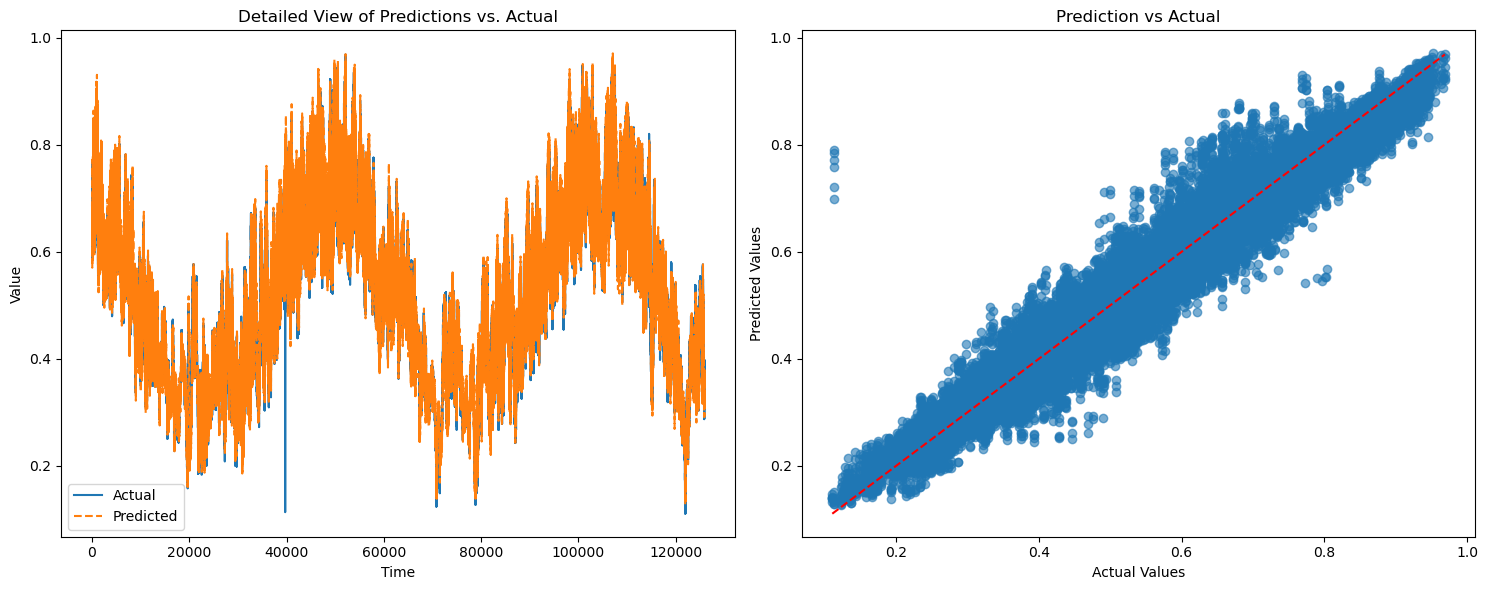

In [28]:

y_pred = model.predict(X_test).flatten()
y_test = y_test.flatten()  # Ensure y_test is flat if it's not already
dummy_array = np.zeros((y_pred.shape[0], feature_count))
dummy_array[:, 3] = y_pred.squeeze() 
test_dummy_array = np.zeros((y_test.shape[0], feature_count))
test_dummy_array[:, 3] = y_test.squeeze()  
test_y = scaler.inverse_transform(test_dummy_array)[:, 3]
predictions_y = scaler.inverse_transform(dummy_array)[:, 3]

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print("MSE ", mse, "RMSE ", rmse, "MAE ", mae)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.plot(y_test, label='Actual', linestyle='-')
plt.plot(y_pred, label='Predicted', linestyle='--')
plt.title('Detailed View of Predictions vs. Actual')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()


# Scatter plot of the actual vs predicted
plt.subplot(1, 2, 2)
plt.scatter(y_test, y_pred, alpha=0.6)
plt.title('Prediction vs Actual')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')  # Ideal predictions line

plt.tight_layout()
plt.show()

https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-04-20T00%3A00&end=2024-04-28T08%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2024_2024_0101
Fetched data successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
https://dataset.api.hub.geosphere.at/v1/timeseries/historical/inca-v1-1h-1km?parameters=RR&parameters=GL&parameters=P0&parameters=T2M&parameters=TD2M&parameters=RH2M&parameters=UU&parameters=VV&start=2024-04-28T08%3A00&end=2024-04-29T00%3A00&lat_lon=48.333056%2C16.631944&lat_lon=48.115278%2C16.175833&output_format=geojson&filename=INCA_Vienna_timeseries_all_parameters_2024_2024_0101


/tmp/ipykernel_24710/421820632.py:13: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_24710/421820632.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



Fetched data successfully


/tmp/ipykernel_24710/421820632.py:13: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.

/tmp/ipykernel_24710/421820632.py:14: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



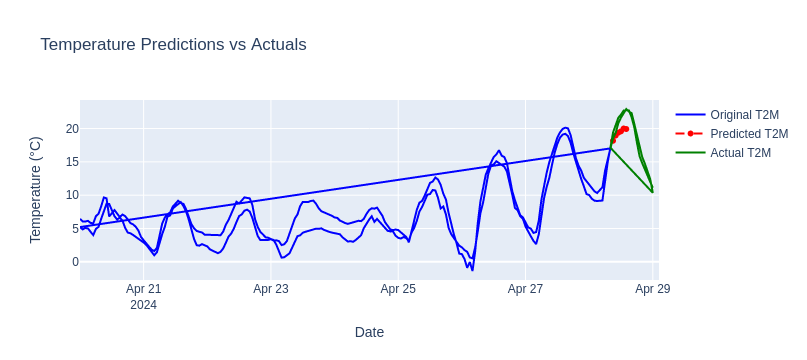

In [46]:
# Assuming 'get_data_for_convlstm' is defined elsewhere and properly implemented
data_for_prediction, time_index_pre_data = get_data_for_convlstm('2024-04-20T00', '2024-04-28T08')

# Ensure scaler is fitted; if it's the first use, fit on some initial data or the current data
scaler = MinMaxScaler()
scaler.fit(data_for_prediction)  # Fit if not already done; else skip

# Transform the data for prediction
df_scaled = scaler.transform(data_for_prediction)
df_scaled = pd.DataFrame(df_scaled, columns=data_for_prediction.columns)
latest_sequence = df_scaled.tail(sequence_length).values.reshape(1, sequence_length, 1, 1, feature_count)
future_temperatures = model.predict(latest_sequence)
dummy_output_array = np.zeros((hours_to_predict, scaler.n_features_in_))
dummy_output_array[:, 3] = future_temperatures.flatten()  # Ensure to flatten if necessary
predicted_temps = scaler.inverse_transform(dummy_output_array)[:, 3]

# Timestamp handling
data_for_prediction.index = time_index_pre_data
last_timestamp = data_for_prediction.index[-1]
prediction_frequency = 'H'
new_timestamps = pd.date_range(start=last_timestamp + pd.Timedelta(hours=1), periods=len(predicted_temps), freq=prediction_frequency)
predictions_df = pd.DataFrame(predicted_temps, index=new_timestamps, columns=['Predicted T2M'])

# Fetch and set the actual data for comparison
data_actual_for_prediction, time_index_actual_data = get_data_for_convlstm('2024-04-28T08', '2024-04-29T00')
data_actual_for_prediction.index = time_index_actual_data

# Plotting the predictions alongside the actual data
fig = go.Figure()
fig.add_trace(go.Scatter(x=data_for_prediction.index, y=data_for_prediction['T2M'], mode='lines', name='Original T2M', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=predictions_df.index, y=predictions_df['Predicted T2M'], mode='lines+markers', name='Predicted T2M', line=dict(color='red', dash='dash')))
fig.add_trace(go.Scatter(x=data_actual_for_prediction.index, y=data_actual_for_prediction['T2M'], mode='lines', name='Actual T2M', line=dict(color='green')))

fig.update_layout(
    title='Temperature Predictions vs Actuals',
    xaxis_title='Date',
    yaxis_title='Temperature (°C)',
    hovermode="x unified"
)

fig.show()


In [32]:
formatted_date_time = datetime.now().strftime("%Y%m%d_%H%M%S")
model_folder_name = f"model_folder{formatted_date_time}"
os.makedirs(model_folder_name, exist_ok=True)
model.save(os.path.join(model_folder_name, 'model.keras'))
joblib.dump(scaler, os.path.join(model_folder_name, 'scaler.pkl'))


['model_folder20240429_171203/scaler.pkl']

In [33]:
loaded_model = tf.keras.models.load_model(os.path.join(model_folder_name, 'model.keras'))
loaded_scaler = joblib.load(os.path.join(model_folder_name, 'scaler.pkl'))


In [ ]:
#end

<xarray.Dataset>
Dimensions:     (number: 1, time: 1, step: 125, surface: 1, latitude: 125,
                 longitude: 93)
Coordinates:
  * number      (number) int64 0
  * time        (time) datetime64[ns] 2017-12-02
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 10 days 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 67.0 66.75 66.5 66.25 ... 36.5 36.25 36.0
  * longitude   (longitude) float64 -6.0 -5.75 -5.5 -5.25 ... 16.5 16.75 17.0
    valid_time  (time, step) datetime64[ns] ...
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-29T19:05 GRIB to CDM+CF via cfgrib-0.9.1...

In [48]:
ds = cml.load_dataset('eumetnet-postprocessing-benchmark-training-data-gridded-forecasts-surface', "2017-12-02", "2t", "highres")
fcs = ds.to_xarray()

By downloading data from this dataset, you agree to the terms and conditions defined at

    https://github.com/Climdyn/climetlab-eumetnet-postprocessing-benchmark/blob/main/DATA_LICENSE

If you do not agree with such terms, do not download the data. 


/home/yjess/anaconda3/lib/python3.11/site-packages/climetlab/sources/indexed_urls.py:46: UserWarning:

Passing a PerUrlIndex object is obsolete, please update your code.



PATTERN {url}data/fcs/{leveltype}/EU_forecast_{kind}_{leveltype}_params_{isodate}_0.grb


EU_forecast_hr_surf_params_2017-12_0.grb:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

In [49]:
obs = ds.get_observations_as_xarray()

PATTERN {url}data/ana/{leveltype}/EU_analysis_{leveltype}_params_{isodate}.grb


/home/yjess/anaconda3/lib/python3.11/site-packages/climetlab/sources/indexed_urls.py:46: UserWarning:

Passing a PerUrlIndex object is obsolete, please update your code.



EU_analysis_surf_params_2017-12.grb:   0%|          | 0.00/5.88M [00:00<?, ?B/s]

In [50]:
obs

<xarray.Dataset>
Dimensions:     (time: 1, step: 125, surface: 1, latitude: 125, longitude: 93,
                 number: 1)
Coordinates:
  * time        (time) datetime64[ns] 2017-12-02
  * step        (step) timedelta64[ns] 00:00:00 01:00:00 ... 10 days 00:00:00
  * surface     (surface) float64 0.0
  * latitude    (latitude) float64 67.0 66.75 66.5 66.25 ... 36.5 36.25 36.0
  * longitude   (longitude) float64 -6.0 -5.75 -5.5 -5.25 ... 16.5 16.75 17.0
  * number      (number) int64 0
    valid_time  (time, step) datetime64[ns] 2017-12-02 ... 2017-12-12
Data variables:
    t2m         (number, time, step, surface, latitude, longitude) float64 27...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-04-29T19:06 GRIB to CDM+CF via cfgrib-0.9.1...

In [66]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math


In [68]:
def generate_ensemble_predictions(model, input_data):
    # Enable dropout at inference time (Monte Carlo Dropout)
    predictions = np.array([model.predict(input_data, training=True) for _ in range(100)])
    ensemble_mean = predictions.mean(axis=0)
    ensemble_std = predictions.std(axis=0)
    return ensemble_mean.flatten(), ensemble_std.flatten()


In [69]:
import numpy as np
from sklearn.linear_model import LinearRegression

# Assuming 'days' is an array of day-of-year values corresponding to the forecasts
X_mu = np.column_stack([
    np.ones(len(days)),  # Intercept
    np.sin(2 * np.pi * days / 365),  # Seasonal functions for DOY
    np.cos(2 * np.pi * days / 365),
    ensemble_mean  # from generate_ensemble_predictions
])

X_sigma = np.column_stack([
    np.ones(len(days)),  # Intercept
    np.sin(2 * np.pi * days / 365),  # Seasonal functions for DOY
    np.cos(2 * np.pi * days / 365),
    np.log(ensemble_std)  # Log of ensemble standard deviations
])

# Fit regression models
model_mu = LinearRegression().fit(X_mu, actual_temperatures)
model_sigma = LinearRegression().fit(X_sigma, np.log(ensemble_std))  # Assuming std dev is available

# Predict adjusted μ and σ
adjusted_mu = model_mu.predict(X_mu)
adjusted_sigma = np.exp(model_sigma.predict(X_sigma))


NameError: name 'ensemble_mean' is not defined

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(actual_temperatures, label='Actual')
plt.plot(adjusted_mu, label='EMOS Adjusted Forecast', color='red')
plt.fill_between(range(len(adjusted_mu)), adjusted_mu - 1.96 * adjusted_sigma, adjusted_mu + 1.96 * adjusted_sigma, color='red', alpha=0.3)
plt.legend()
plt.show()


In [67]:

# Sample data
np.random.seed(0)
days = np.array(range(365))  # Day of the year for one year
mu_ens = np.random.normal(20, 5, 365)  # Simulated ensemble mean predictions
sigma_ens = np.random.normal(2, 0.5, 365)  # Simulated ensemble standard deviations
temps_actual = mu_ens + np.random.normal(0, sigma_ens)  # Simulated actual temperatures

# Features for EMOS
X = np.column_stack([
    np.ones(len(days)),  # Intercept
    np.sin(2 * np.pi * days / 365),
    np.cos(2 * np.pi * days / 365),
    np.sin(4 * np.pi * days / 365),
    np.cos(4 * np.pi * days / 365),
    mu_ens  # Using ensemble mean as a feature
])

# Linear model for μ
model_mu = LinearRegression().fit(X, temps_actual)

# Predicting μ
mu_pred = model_mu.predict(X)

# Linear model for log(σ)
log_sigma = np.log(np.abs(temps_actual - mu_pred))  # Approximation of σ
model_sigma = LinearRegression().fit(X, log_sigma)
sigma_pred = np.exp(model_sigma.predict(X))

# Printing models' coefficients
print("Mu coefficients:", model_mu.coef_)
print("Sigma coefficients:", model_sigma.coef_)

Mu coefficients: [ 0.         -0.203804   -0.15900375  0.19971353 -0.21970924  1.02800792]
Sigma coefficients: [ 0.          0.00121097 -0.01989506 -0.12524565  0.13854328 -0.0162542 ]
